In [1]:
# Exploring the Home Credit Dataset (application_train.csv)

# 1. Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter


In [2]:
# Create the Data Paths and define Target
DATA_PATH = Path("../data/raw/application_train.csv")
OUT_DIR = Path("../data/clean/")
TARGET = "TARGET"
UNIQUE_KEY = "SK_ID_CURR"

In [3]:
# Load the data
df = pd.read_csv(DATA_PATH)
orig_shape = df.shape

In [4]:
# Create Helper functions to group very rare categories.
def safe_div(a, b):
    return np.where((b==0) | (pd.isna(b)), np.nan, a / b)

def reduce_rare(series, min_ratio=0.005):
    """Group very rare categories (<0.5%) into 'Other'."""
    vc = series.value_counts(normalize=True, dropna=False)
    keep = set(vc[vc >= min_ratio].index)
    return series.where(series.isin(keep), other="Other")

In [5]:
# Explore the dataset
missing = df.isna().sum().sort_values(ascending=False).to_frame("n_missing")
missing["pct_missing"] = (missing["n_missing"]/len(df)*100).round(2)
missing.to_csv(OUT_DIR/"missing_summary.csv")

with open(OUT_DIR/"quick_info.txt","w") as f:
    f.write(f"Rows x Cols: {df.shape}\n")
    if TARGET in df:
        f.write(df[TARGET].value_counts().to_string()+"\n")

/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_96806/3191434829.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns. barplot(


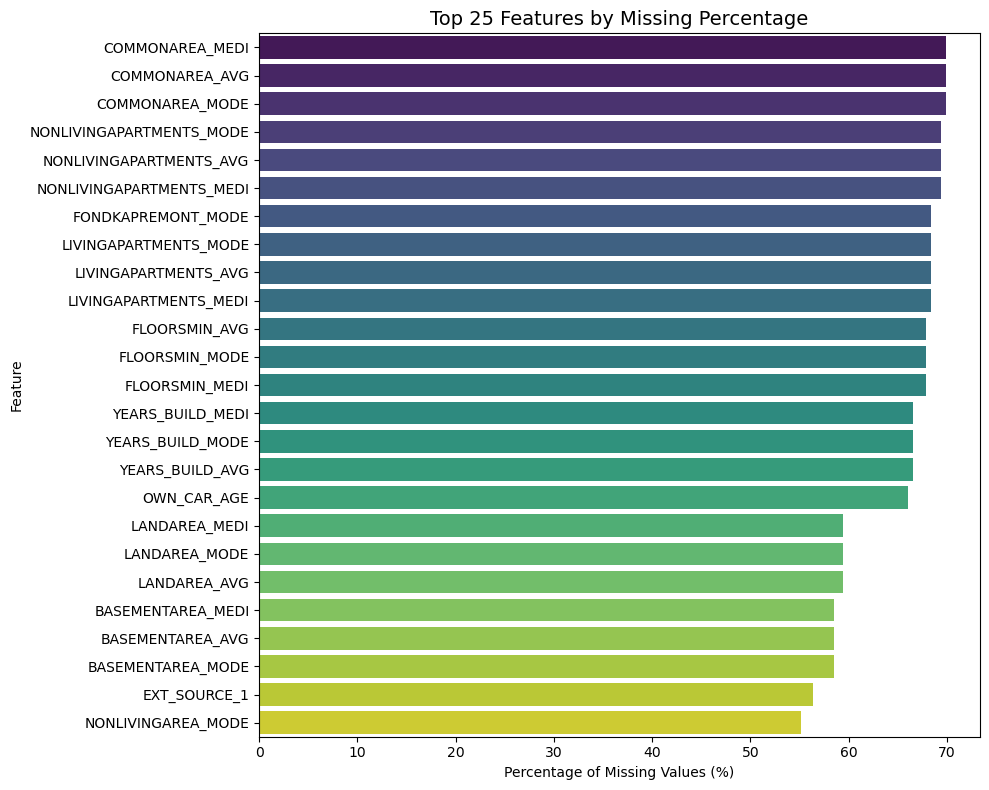

In [6]:
# Show the top 25 features with missing values.
top_n = 25
top_missing = missing.head(top_n).reset_index()
top_missing.columns = ["Feature", "MissingCount", "MissingPct"]

# Seaborn barplot
plt.figure(figsize=(10, 8))
sns. barplot(
    data=top_missing,
    y="Feature", x="MissingPct",
    palette="viridis"
)
plt.title(f"Top {top_n} Features by Missing Percentage", fontsize=14)
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [7]:
# Perform Data Quality Checks
dq = {}
dq["unique_ids"] = (df[UNIQUE_KEY].is_unique if UNIQUE_KEY in df.columns else "UNAVAILABLE")
dq["duplicate_rows"] = int(df.duplicated().sum())
dq["constant_columns"] = [c for c in df.columns if df[c].nunique(dropna=False) == 1]
dq["high_missing_over_60pct"] = missing.index[missing["pct_missing"]>=60].tolist()

if "DAYS_EMPLOYED" in df:
    dq["DAYS_EMPLOYED_365243_count"] = int((df["DAYS_EMPLOYED"]==365243).sum())
if "CODE_GENDER" in df:
    dq["CODE_GENDER_counts"] = df["CODE_GENDER"].value_counts(dropna=False).to_dict()

pd.Series(dq, dtype="object").to_json(OUT_DIR/"data_quality_checks.json", indent=2)

In [8]:
# Data Cleaning
dfc = df.copy() # Create a copy of the datafrane

# 1) sentinel in DAYS_EMPLOYED
if "DAYS_EMPLOYED" in dfc:
    dfc.loc[dfc["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan

# 2) check for rare/invalid gender label
if "CODE_GENDER" in dfc:
    dfc.loc[dfc["CODE_GENDER"] == "XNA", "CODE_GENDER"] = np.nan

# 3) check for impossible counts -> NaN
for c in ["CNT_CHILDREN", "CNT_FAM_MEMBERS"]:
    if c in dfc:
        dfc.loc[dfc[c] < 0, c] = np.nan

In [9]:
# Feature Engineering
fe = dfc.copy()

# Make sure the years are human-readable
if "DAYS_BIRTH" in fe:
    fe["AGE_YEARS"] = (-fe["DAYS_BIRTH"]/365.25).round(2)
if "DAYS_EMPLOYED" in fe:
    fe["EMPLOYED_YEARS"] = (-fe["DAYS_EMPLOYED"]/365.25).round(2)

# ratios
if {"AMT_CREDIT","AMT_INCOME_TOTAL"}.issubset(fe.columns):
    fe["CREDIT_TO_INCOME"] = safe_div(fe["AMT_CREDIT"], fe["AMT_INCOME_TOTAL"])
if {"AMT_ANNUITY","AMT_INCOME_TOTAL"}.issubset(fe.columns):
    fe["ANNUITY_TO_INCOME"] = safe_div(fe["AMT_ANNUITY"], fe["AMT_INCOME_TOTAL"])
if {"AMT_ANNUITY","AMT_CREDIT"}.issubset(fe.columns):
    fe["PAYMENT_RATE"] = safe_div(fe["AMT_ANNUITY"], fe["AMT_CREDIT"])
if {"AMT_GOODS_PRICE","AMT_CREDIT"}.issubset(fe.columns):
    fe["GOODS_CREDIT_RATIO"] = safe_div(fe["AMT_GOODS_PRICE"], fe["AMT_CREDIT"])

# household
if {"CNT_CHILDREN","CNT_FAM_MEMBERS"}.issubset(fe.columns):
    fe["CHILDREN_RATIO"] = safe_div(fe["CNT_CHILDREN"], fe["CNT_FAM_MEMBERS"])
if {"AMT_INCOME_TOTAL","CNT_FAM_MEMBERS"}.issubset(fe.columns):
    fe["INCOME_PER_PERSON"] = safe_div(fe["AMT_INCOME_TOTAL"], fe["CNT_FAM_MEMBERS"])

# docs aggregate
doc_cols = [c for c in fe.columns if c.startswith("FLAG_DOCUMENT")]
if doc_cols:
    fe["N_DOCS_PROVIDED"] = fe[doc_cols].sum(axis=1)

# EXT_SOURCE aggregates
ext_cols = [c for c in fe.columns if c.startswith("EXT_SOURCE")]
if ext_cols:
    fe["EXT_SOURCES_MEAN"] = fe[ext_cols].mean(axis=1)
    fe["EXT_SOURCES_MIN"]  = fe[ext_cols].min(axis=1)
    fe["EXT_SOURCES_MAX"]  = fe[ext_cols].max(axis=1)

# log transforms for skewed amounts
for col in ["AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY","AMT_GOODS_PRICE"]:
    if col in fe:
        fe[f"LOG1P_{col}"] = np.log1p(fe[col].clip(lower=0))

In [10]:
# Imputation and Encoding
num_cols = fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = fe.select_dtypes(include=["object"]).columns.tolist()

# numeric: median; categorical: "Missing"
fe[num_cols] = fe[num_cols].fillna(fe[num_cols].median())
fe[cat_cols] = fe[cat_cols].fillna("Missing")

In [11]:
# Reduce the rare categories
for c in cat_cols:
    fe[c] = reduce_rare(fe[c], min_ratio=0.005)

In [12]:
# Drop columns with 80%+ missin
cols_to_consider_drop = set(missing.index[missing["pct_missing"]>=80].tolist())
cols_to_drop = [c for c in fe.columns if c in cols_to_consider_drop]

In [13]:
n_sample = min(20000, len(fe))
fe_sample = fe.iloc[:n_sample].copy()
model_matrix_sample = pd.get_dummies(fe_sample, columns=cat_cols, dummy_na=False)


In [14]:
# Check for correlation
if TARGET in fe:
    numeric_cols = fe.select_dtypes(include=[np.number]).columns
    corr = fe[numeric_cols].corrwith(df[TARGET]).sort_values(ascending=False)
    corr.to_frame("corr_with_TARGET").to_csv(OUT_DIR/"feature_target_correlations.csv")

In [15]:
fe.head(10000).to_csv(OUT_DIR/"application_train_engineered_sample.csv", index=False) 
model_matrix_sample.to_csv(OUT_DIR/"application_train_model_matrix_sample.csv", index=False)


In [16]:
# Create Plots for AGE Years and Employed Years
plt.figure()
df[TARGET].value_counts().sort_index().plot(kind="bar")
plt.title("TARGET distribution (0=repaid, 1=default)")
plt.xlabel("TARGET"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(OUT_DIR/"target_distribution.png"); plt.close()

if "AGE_YEARS" in fe:
    plt.figure()
    fe["AGE_YEARS"].dropna().plot(kind="hist", bins=40)
    plt.title("Distribution of AGE_YEARS"); plt.xlabel("Age (years)"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(OUT_DIR/"hist_age_years.png"); plt.close()

if "EMPLOYED_YEARS" in fe:
    plt.figure()
    fe["EMPLOYED_YEARS"].dropna().clip(upper=60).plot(kind="hist", bins=40)
    plt.title("Distribution of EMPLOYED_YEARS (clipped at 60)"); plt.xlabel("Years"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(OUT_DIR/"hist_employed_years.png"); plt.close()

In [17]:
summary = {
    "raw_shape": df.shape,
    "engineered_shape": fe.shape,
    "model_matrix_sample_shape": model_matrix_sample.shape,
    "dropped_candidates(>=80%missing)_count": len(cols_to_drop),
}
pd.Series(summary, dtype="object").to_csv(OUT_DIR/"summary_stats.csv")

print("Done. See ./outputs for CSVs & PNGs.")

Done. See ./outputs for CSVs & PNGs.


In [18]:
df_summary = pd.DataFrame({
    "n_rows": [fe.shape[0]],
    "n_cols": [fe.shape[1]],
    "n_numeric": [fe.select_dtypes(include=np.number).shape[1]],
    "n_categorical": [fe.select_dtypes(exclude=np.number).shape[1]],
    "pct_missing_any": [fe.isna().any().mean() * 100],
    "pct_rows_with_missing": [(fe.isna().sum(axis=1) > 0).mean() * 100],
    "duplicate_rows": [fe.duplicated().sum()]
})
print("🔹 Overall Dataset Summary:")
display(df_summary)

missing_summary = fe.isna().sum().sort_values(ascending=False)
missing_summary = (missing_summary[missing_summary > 0] / len(fe) * 100).round(2)
print("\n🔹 Columns with Missing Values (%):")
display(missing_summary.head(20))  # show top 20


print("\n🔹 Numeric Columns Summary:")
display(fe.describe().T)

cat_cols = fe.select_dtypes(exclude=np.number).columns
if len(cat_cols):
    cat_summary = fe[cat_cols].nunique().sort_values(ascending=False)
    print("\n🔹 Categorical Columns – Number of Unique Values:")
    display(cat_summary.head(20))
else:
    print("\n(No categorical columns left after encoding)")

if "TARGET" in fe.columns:
    corr = fe.corr(numeric_only=True)["TARGET"].sort_values(ascending=False)
    print("\n🔹 Top 20 Correlations with TARGET:")
    display(corr.head(20))

🔹 Overall Dataset Summary:


,n_rows,n_cols,n_numeric,n_categorical,pct_missing_any,pct_rows_with_missing,duplicate_rows
0,307511,138,122,16,0.0,0.0,0



🔹 Columns with Missing Values (%):


Series([], dtype: float64)


🔹 Numeric Columns Summary:


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.000000,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.000000,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.000000,270000.000000,513531.000000,808650.000000,4.050000e+06
...,...,...,...,...,...,...,...,...
EXT_SOURCES_MAX,307511.0,0.615900,0.156089,0.000006,0.540654,0.648470,0.725276,9.626928e-01
LOG1P_AMT_INCOME_TOTAL,307511.0,11.909245,0.488906,10.152338,11.630717,11.899215,12.218500,1.857768e+01
LOG1P_AMT_CREDIT,307511.0,13.070108,0.715193,10.714440,12.506181,13.149068,13.603123,1.521423e+01
LOG1P_AMT_ANNUITY,307511.0,10.067677,0.545872,7.388019,9.712630,10.122784,10.451522,1.246082e+01



🔹 Categorical Columns – Number of Unique Values:


ORGANIZATION_TYPE             29
OCCUPATION_TYPE               15
WALLSMATERIAL_MODE             8
WEEKDAY_APPR_PROCESS_START     7
NAME_TYPE_SUITE                6
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               5
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             5
CODE_GENDER                    3
HOUSETYPE_MODE                 3
EMERGENCYSTATE_MODE            3
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
dtype: int64


🔹 Top 20 Correlations with TARGET:


TARGET                         1.000000
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                  0.063368
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032394
DEF_60_CNT_SOCIAL_CIRCLE       0.031401
FLAG_WORK_PHONE                0.028524
CHILDREN_RATIO                 0.021224
CNT_CHILDREN                   0.019187
N_DOCS_PROVIDED                0.017193
OWN_CAR_AGE                    0.015982
Name: TARGET, dtype: float64